<a href="https://colab.research.google.com/github/shahabday/NLP_learning/blob/main/FineTune_GPT2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -U transformers[torch] datasets accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 484.9/484.9 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 103.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 33.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
import glob
import os
import shutil
import tqdm
import random
import matplotlib.pyplot as plt
import torch
from datasets import load_dataset
from tokenizers import Tokenizer
from tokenizers.models import BPE
from tokenizers.trainers import BpeTrainer
from tokenizers.pre_tokenizers import Whitespace
from transformers import PreTrainedTokenizerFast
from transformers import DataCollatorForLanguageModeling
from transformers import GPT2Config, GPT2LMHeadModel
from transformers import TrainingArguments, Trainer

tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Load Dataset

In [ ]:
import os
import kagglehub
import shutil

# Define the folder where the dataset will be stored
output_folder = "/content/scripts"

# Ensure the directory exists
os.makedirs(output_folder, exist_ok=True)

# Download the dataset
path = kagglehub.dataset_download("divyansh22/friends-tv-show-script")

print("✅ Dataset downloaded and saved in:", path)

# Copy all files from the source path to the destination
shutil.copytree(path, output_folder, dirs_exist_ok=True)



100%|██████████| 1.67M/1.67M [00:00<00:00, 126MB/s]

Extracting files...
✅ Dataset downloaded and saved in: /root/.cache/kagglehub/datasets/divyansh22/friends-tv-show-script/versions/1


'/content/scripts'

In [ ]:
dataset_file = '/content/scripts/Friends_Transcript.txt'
raw_datasets = load_dataset("text", data_files=[dataset_file])
raw_datasets

Generating train split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 66540
    })
})

In [ ]:
for index in range(10):
    token_sequence = raw_datasets["train"][index]["text"]
    print(token_sequence)

THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)
Written by: Marta Kauffman & David Crane
[Scene: Central Perk, Chandler, Joey, Phoebe, and Monica are there.]
Monica: There's nothing to tell! He's just some guy I work with!
Joey: C'mon, you're going out with the guy! There's gotta be something wrong with him!
Chandler: All right Joey, be nice. So does he have a hump? A hump and a hairpiece?
Phoebe: Wait, does he eat chalk?
(They all stare, bemused.)
Phoebe: Just, 'cause, I don't want her to go through what I went through with Carl- oh!
Monica: Okay, everybody relax. This is not even a date. It's just two people going out to dinner and- not having sex.


## Training pre trained GPT2

### Tokenizer

In [ ]:


tokenizer = Tokenizer(BPE(unk_token="[UNK]"))
trainer = BpeTrainer(vocab_size=5000, special_tokens=["[UNK]", "[PAD]"])
tokenizer.pre_tokenizer = Whitespace()

def batch_iterator(batch_size=1000):
    for i in range(0, len(raw_datasets["train"]), batch_size):
        yield raw_datasets["train"][i : i + batch_size]["text"]

tokenizer.train_from_iterator(batch_iterator(), trainer=trainer, length=len(raw_datasets["train"]))
tokenizer.save("tokenizer.json")

tokenizer = PreTrainedTokenizerFast(tokenizer_file="tokenizer.json")
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

0

In [ ]:
tokenizer.vocab_size

5000

In [ ]:
from transformers import GPT2Tokenizer

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

#### check the tokenizer

In [ ]:
token_sequence = raw_datasets["train"][3]["text"]
print(token_sequence)

indices = tokenizer(token_sequence)["input_ids"]
print(indices)

tokens = [tokenizer.decode([index]) for index in indices]
print(tokens)
print(len(tokens))

Monica: There's nothing to tell! He's just some guy I work with!
[9069, 3970, 25, 1318, 338, 2147, 284, 1560, 0, 679, 338, 655, 617, 3516, 314, 670, 351, 0]
['Mon', 'ica', ':', ' There', "'s", ' nothing', ' to', ' tell', '!', ' He', "'s", ' just', ' some', ' guy', ' I', ' work', ' with', '!']
18


100%|██████████| 66540/66540 [00:17<00:00, 3830.92it/s]


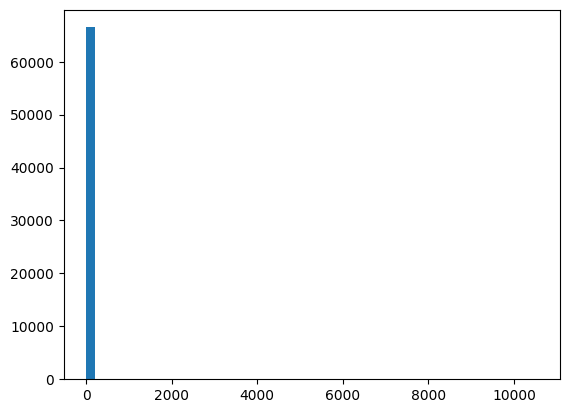

In [ ]:
lengths = []
for token_sequence in tqdm.tqdm(raw_datasets["train"]):
    token_sequence = token_sequence["text"]
    indices = tokenizer(token_sequence)["input_ids"]
    lengths += [len(indices)]

plt.hist(lengths, bins=50)
plt.show()

## train the model

In [ ]:
sequence_length = 256

def tokenize_function(example):
    tokenized_example = tokenizer(
        example["text"],
        truncation=True,
        padding=True,
        max_length=sequence_length,
    )
    return {
        "input_ids": tokenized_example["input_ids"]
    }

# Check a sample.
token_sequence = raw_datasets["train"][0]
print(token_sequence)
tokenized = tokenize_function(token_sequence)
assert list(tokenized.keys()) == ["input_ids"], list(tokenized.keys())
print(tokenized)

{'text': 'THE ONE WHERE MONICA GETS A NEW ROOMATE (THE PILOT-THE UNCUT VERSION)'}
{'input_ids': [10970, 16329, 33411, 25000, 25241, 17151, 50, 317, 12682, 15107, 2662, 6158, 357, 10970, 350, 4146, 2394, 12, 10970, 39151, 3843, 44156, 2849, 8]}


In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True, remove_columns=raw_datasets["train"].column_names)

# Check a sample.
tokenized = tokenized_datasets["train"][0]
assert list(tokenized.keys()) == ["input_ids"], list(tokenized.keys())
print(tokenized)

Map:   0%|          | 0/66540 [00:00<?, ? examples/s]

{'input_ids': [10970, 16329, 33411, 25000, 25241, 17151, 50, 317, 12682, 15107, 2662, 6158, 357, 10970, 350, 4146, 2394, 12, 10970, 39151, 3843, 44156, 2849, 8, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,

In [ ]:
data_collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

In [ ]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
model

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

input_ids: tensor([[   58, 36542,    25,  5694,  2448,    74,    11, 28346,    11, 26154,
            11,  1380,  2577,  1350,    11,   290, 23240,   389,   612,  8183,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5025

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


logits: tensor([[[ -35.1763,  -33.5168,  -35.3033,  ...,  -42.8390,  -43.4409,
           -35.0897],
         [ -72.1811,  -71.1347,  -68.4316,  ...,  -77.4827,  -81.1316,
           -72.6749],
         [ -73.4369,  -73.9256,  -71.0827,  ...,  -76.6761,  -78.6836,
           -69.6642],
         ...,
         [ -96.8161,  -89.9486,  -92.5594,  ..., -111.7779, -111.9662,
           -99.7331],
         [ -96.8275,  -89.9550,  -92.5666,  ..., -111.7917, -111.9829,
           -99.7440],
         [ -96.7931,  -89.9271,  -92.5364,  ..., -111.7520, -111.9462,
           -99.6994]]], grad_fn=<UnsafeViewBackward0>)


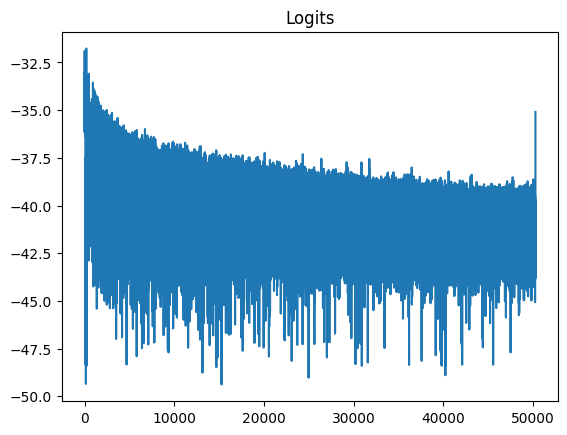

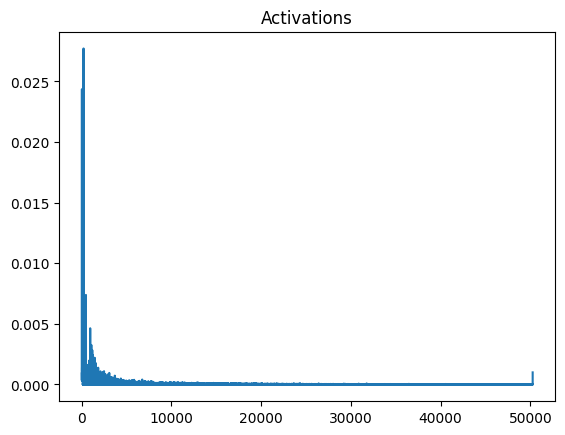

In [ ]:
inputs = [tokenized_datasets["train"][2]]
inputs = data_collator(inputs)
assert list(inputs.keys()) == ["input_ids", "attention_mask", "labels"], list(inputs.keys())
print("input_ids:", inputs["input_ids"])
print("")

outputs = model(**inputs)
assert list(outputs.keys()) == ["loss", "logits", "past_key_values"], list(outputs.keys())
print("logits:", outputs["logits"])

plt.plot(outputs["logits"].detach().numpy()[0][0])
plt.title("Logits")
plt.show()
plt.close()

activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
plt.plot(activations.detach().numpy()[0][0])
plt.title("Activations")
plt.show()
plt.close()

## Training

In [ ]:
# Get the output directory with timestamp.
output_path = "output"

# Create the trainer.
print("Creating trainer...")
training_args = TrainingArguments(
    output_dir=output_path,
    overwrite_output_dir=True,
    num_train_epochs=2,
    per_device_train_batch_size=72,
    prediction_loss_only=False,
    #report_to="none"
)
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=tokenized_datasets["train"],
)

# Train the model.
trainer.train()

# Save the tokenizer.
tokenizer.save_pretrained(output_path)

# Save the model.
model.save_pretrained(output_path)

Creating trainer...


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: shahabdaiani (shahabdaiani-dsr) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Step,Training Loss
500,3.046100
1000,2.887700
1500,2.781800


Step,Training Loss
500,3.046100
1000,2.887700
1500,2.781800


In [1]:
inputs = [tokenized_datasets["train"][2]]
inputs = data_collator(inputs)
assert list(inputs.keys()) == ["input_ids", "attention_mask", "labels"], list(inputs.keys())
print("input_ids:", inputs["input_ids"])
print("")

outputs = model(**inputs.to("cuda:0"))
assert list(outputs.keys()) == ["loss", "logits", "past_key_values"], list(outputs.keys())
print("logits:", outputs["logits"])

plt.plot(outputs["logits"].cpu().detach().numpy()[0][0])
plt.title("Logits")
plt.show()
plt.close()

activations = torch.nn.functional.softmax(outputs["logits"], dim=-1)
plt.plot(activations.cpu().detach().numpy()[0][0])
plt.title("Activations")
plt.show()
plt.close()

NameError: name 'tokenized_datasets' is not defined

## Generate

In [ ]:
model.to("cuda")

# Encode the conditioning tokens.
input_ids = tokenizer.encode("The most merciful thing in the world, I think, is the inability of the human mind to correlate all its contents.", return_tensors="pt").cuda()
print(input_ids)

# Generate more tokens.
generated_ids = model.generate(
    input_ids,
    max_length=100,
    do_sample=True,
    temperature=0.5
)
generated_sequence = tokenizer.decode(generated_ids[0], clean_up_tokenization_spaces=True)
print(generated_sequence)